In [0]:
from fastai import *
from fastai.text import *
from pathlib import Path
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re

In [0]:
def clean_ascii(text):
    # function to remove non-ASCII characters from data
    return ''.join(i for i in text if ord(i) < 128)

In [0]:
# path to training files
trainfile = 'data.csv'
trainfile2 = 'hateData.txt'

In [7]:
# read 2nd training file into dataframe
train_data_hate = pd.read_csv(trainfile2, delimiter='\t', header=None, encoding = "latin-1")
train_data_hate.columns =["Label", "Tweet"] # assing column names
train_data_hate['Tweet'] = train_data_hate['Tweet'].apply(clean_ascii) # clean Tweets

train_data_hate.head() # overview


,Label,Tweet
0,offensive,Warning: penny boards will make you a faggot
1,hatespeech,Fuck dykes
2,hatespeech,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandon...
3,hatespeech,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkill..."
4,offensive,@Zhugstubble You heard me bitch but any way I'...


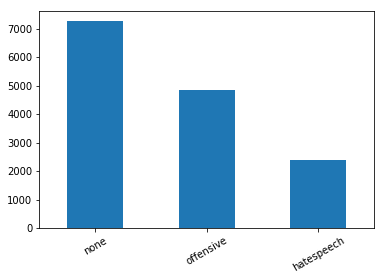

In [6]:
# Class disstribution in hate speech data
train_data_hate['Label'].value_counts().plot.bar(rot=30);

In [0]:
# Split data into train and test data with 80:20 ratio
train, test = train_test_split(train_data_hate, test_size=0.2)

#print(train['Label'].value_counts())
#print(test['Label'].value_counts())

# Write train & test to csv
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_csv('./', 'train.csv', min_freq=1)

In [0]:
# Save the language and classifier model data for re-use
data_lm.save()

In [11]:
data_lm.show_batch()

idx,text
0,"xxbos xxmaj rt this if you r directioner \n -follow me \n -follow everyone who rts this \n -follow back whoever follows you \n # weareall1d https : / / t.co / 6g3qex0vua xxbos xxmaj lmao whole video birdman talking about some niggas in the crowd haha "" i fuck with niggas too "" \n xxmaj straight from his ... https : / / t.co"
1,"kid who are an active part of our ministry do n't pay for anything . xxmaj kids from community must find their own cost . xxmaj need or none xxbos xxmaj we 're # hiring ! xxmaj read about our latest # job opening here : xxmaj cook - https : / / t.co / jacbcntwhg # xxup sonic # xxmaj bend , xxup or # xxmaj hospitality # careerarc"
2,a faggot and join the marine corps xxbos xxmaj stop all that coon shit xxbos i xxup hate xxup all xxup of xxup yu https : / / t.co / u7zfsvgrc9 xxbos xxmaj dealing with niggas is so fucking jarring . xxmaj bye xxbos xxmaj this guy says women in xxmaj india deserve to be # raped . xxmaj and this # video makes me agree with him : https
3,n't have ( miniature ) horses that come to xxup your job https : / / t.co / pheq4hnwbi xxbos @a_skar38 xxmaj well at least you did n't see it flopping around like i did when i took the picture . xxbos xxmaj gain 8513 _ _ _ _ _ _ _ _ _ _ _ _ . with https : / / t.co / xxup io6vduga00 @ ( sponsored
4,"their heads . # yogiberra xxbos @the_enforcer2 she was like omg what a fag and laughed _ xxbos @viperlization we did nt get raped as you said you would xxbos xxmaj follow me pls ? no ? hate you xxmaj lucas : _ _ ( ( https : / / t.co / mkt7gmylha xxbos hbd to the biggest faggot i know , congrats on the l xxrep 4 _ https"


In [0]:
#learner object uses the tokenized language model data
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


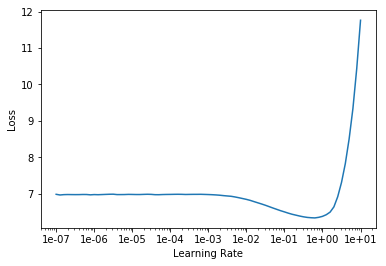

In [13]:
#Find the optimum learning rate
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [14]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.677720,5.712463,0.171522,00:09


In [15]:
learn.unfreeze()
learn.fit_one_cycle(cyc_len=20, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.764269,4.921342,0.236719,00:12
1,5.439770,4.811149,0.254948,00:12
2,5.146151,4.620282,0.283761,00:12
3,4.857198,4.482448,0.301469,00:12
4,4.536485,4.322469,0.320350,00:12
5,4.231594,4.210819,0.331529,00:12
6,3.926303,4.202949,0.339621,00:12
7,3.609680,4.237667,0.343136,00:13
8,3.326225,4.275714,0.344643,00:13
9,3.046193,4.322361,0.348456,00:13


In [0]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_csv('./', 'train.csv', vocab=data_lm.train_ds.vocab,min_freq=1, bs=32)
data_clas.save()

In [0]:
learn = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


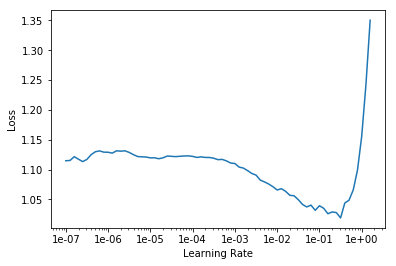

In [19]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.834585,0.757375,0.657623,00:06


In [21]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.706980,0.587054,0.739018,00:07


In [22]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.610073,0.516358,0.764858,00:12


In [23]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.586111,0.503832,0.765289,00:14
1,0.554335,0.491963,0.778639,00:15
2,0.533066,0.487304,0.780792,00:16
3,0.501121,0.466303,0.790267,00:16
4,0.476038,0.465272,0.796727,00:16
5,0.435299,0.467748,0.799311,00:15
6,0.395022,0.475237,0.799742,00:16
7,0.377530,0.489038,0.801034,00:16
8,0.358209,0.489043,0.798450,00:16
9,0.339120,0.489293,0.796296,00:16


In [25]:
# get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,202,18,161
1,13,1102,58
2,156,67,545


In [0]:
learn.export('trained_classifier.pkl')